In [21]:
# import en_core_web_lg
from spacy.util import minibatch, compounding
from spacy.training import Example
import spacy
import warnings
import json
import random
import spacy

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
from utils.helpers import compute_scores, extract_entities_span, generate_batches

In [22]:
sns.set_theme()

# 1. Preparing Spacy NER model For Training

## 1.1. Loading Training Data & Spacy Pretrained Model

In [3]:
spacy.prefer_gpu()

True

In [4]:
# nlp = en_core_web_trf.load()
nlp=spacy.load('en_core_web_lg')

In [13]:
# Read data from disk
training_set = []
with open('./data/food_ner_dataset_training.jsonl', 'r', encoding='utf-8') as file:
    for line in tqdm(file.readlines()):
        training_set.append(json.loads(line))

In [14]:
# Read data from disk
test_set = []
with open('./data/food_ner_dataset_test.jsonl', 'r', encoding='utf-8') as file:
    for line in tqdm(file.readlines()):
        test_set.append(json.loads(line))

## 1.2. Adding New Entities

In [7]:
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [8]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")

In [9]:
entities_to_be_added = set()

for row in training_set:
    for ent in row[1]['entities']:
        entities_to_be_added.add(ent[2])

# Removing labels that already exists in the ner.labels
entities_to_be_added = entities_to_be_added - set(ner.labels)

In [10]:
for ent in entities_to_be_added:
    ner.add_label(ent)

# 2. Training

In [15]:
# start the training loop, only training NER
metrics = []
losses = []
epochs = 50 # Optimum number of epochs based on the results
batch_size= 48 # Change the batch size based on your hardware configuration
optimizer = nlp.resume_training()

In [ ]:
with nlp.disable_pipes(*disabled_pipes):
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        # Shuffling training samples
        random.shuffle(training_set)
        batches = generate_batches(training_set, size=batch_size, nlp=nlp)
        loss = {}
        for batch in tqdm(batches, total=len(training_set)//batch_size+1):
            nlp.update( batch,  
                    sgd=optimizer,
                    drop=0.35,
                    losses=loss,
                )
        # Appending to the list
        losses.append(loss)
        # Calculating test metrics
        if (epoch+1)%5==0:
            metric = compute_scores(test_set, nlp)
            metric.update(dict(epoch=epoch))
            metrics.append(metric)
        print("Losses ({}/{})".format(epoch + 1, epochs), loss)

## 2.2. Saving the trained model and metrics

In [50]:
# Saving Trained Model
nlp.to_disk("./models/spacy/spacy_ner_v1/")

In [52]:
# Saving the results of train losses and test metrics
pd.DataFrame(metrics).to_csv('./models/spacy_ner_v1/test_metrics_v10.csv', index=False, encoding='utf-8')
pd.DataFrame(losses).reset_index(drop=False).rename(columns={'index':'epoch'}).to_csv('./models/spacy_ner_v1/train_loss_v10.csv', index=False, encoding='utf-8')

# 3. Visualizing Train Loss & Test metrics

In [28]:
train_losses = pd.read_csv('./models/spacy_ner_v1/train_loss_v10.csv')

In [19]:
test_metrics = pd.read_csv('./models/spacy_ner_v1/test_metrics_v10.csv').set_index('epoch').stack().reset_index(drop=False).rename(columns={'level_1':'metric', 0:'value'})

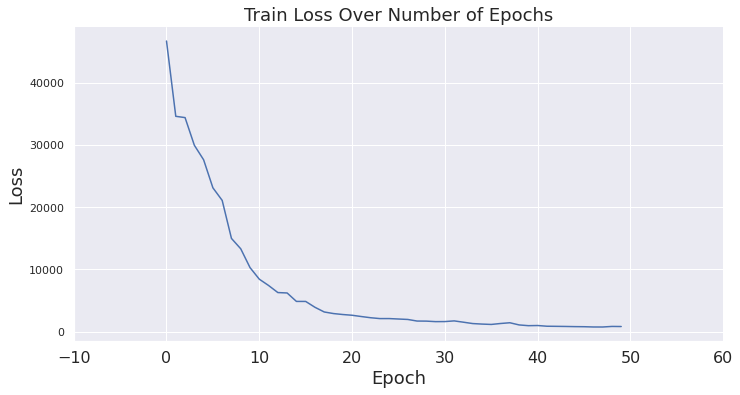

In [31]:
g = sns.relplot(data=pd.DataFrame(train_losses).reset_index(drop=False), x='index', y='ner', kind='line', height=5, aspect=2);
g.ax.set_title('Train Loss Over Number of Epochs', fontsize=18);
g.set_xticklabels(fontsize=16, );
g.set_xlabels(fontsize=18, label='Epoch');
g.set_ylabels(fontsize=18, label="Loss");

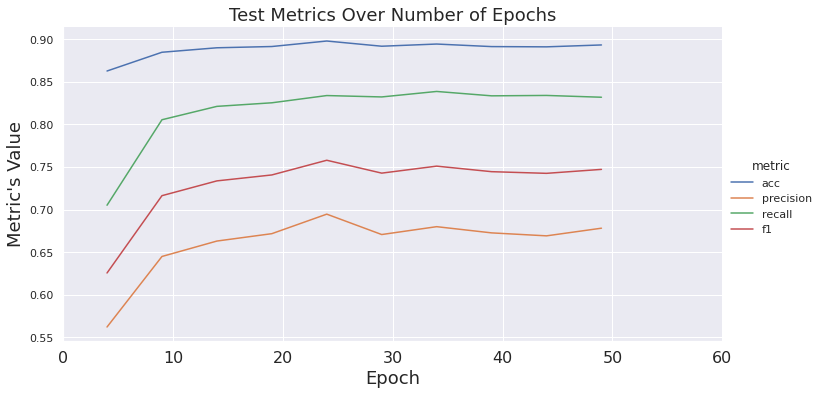

In [27]:
g = sns.relplot(data=test_metrics, x='epoch', y='value', hue='metric', kind='line', height=5, aspect=2);
g.ax.set_title('Test Metrics Over Number of Epochs', fontsize=18);
g.set_xticklabels(fontsize=16, );
g.set_xlabels(fontsize=18, label='Epoch');
g.set_ylabels(fontsize=18, label="Metric's Value");

# 4. Visualizing one of the examples in the test

In [55]:
sample = test_set[0]
doc = nlp(sample[0])

In [ ]:
# display sentence involving original entities
spacy.displacy.render(doc, style="ent")